In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Add, AveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
base_units = 32
exp_conv = Sequential()

exp_conv.add(Input((72, 72, 3)))

# conv 1
exp_conv.add(Conv2D(filters=base_units * 2, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 2
exp_conv.add(Conv2D(filters=base_units * 2, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.2))

# conv 3
exp_conv.add(Conv2D(filters=base_units * 4, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 4
exp_conv.add(Conv2D(filters=base_units * 4, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.3))

# conv 5
exp_conv.add(Conv2D(filters=base_units * 8, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 6
exp_conv.add(Conv2D(filters=base_units * 8, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 7
exp_conv.add(Conv2D(filters=base_units * 8, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 8

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.4))

# conv 9
exp_conv.add(Conv2D(filters=base_units * 16, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 10
exp_conv.add(Conv2D(filters=base_units * 16, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.4))

# conv 11
exp_conv.add(Conv2D(filters=base_units * 16, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# conv 12
exp_conv.add(Conv2D(filters=base_units * 16, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(3, 3)))
exp_conv.add(Dropout(0.4))

# fully connected
exp_conv.add(Flatten())
exp_conv.add(Dense(units=1024, activation=relu))
exp_conv.add(Dropout(0.5))
exp_conv.add(Dense(units=1024, activation=relu))
exp_conv.add(Dropout(0.5))
exp_conv.add(Dense(units=2, activation=softmax))

exp_conv.summary()

2022-01-27 12:17:23.005729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 12:17:23.148105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 12:17:23.148896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 12:17:23.150146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 72, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 72, 72, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       7

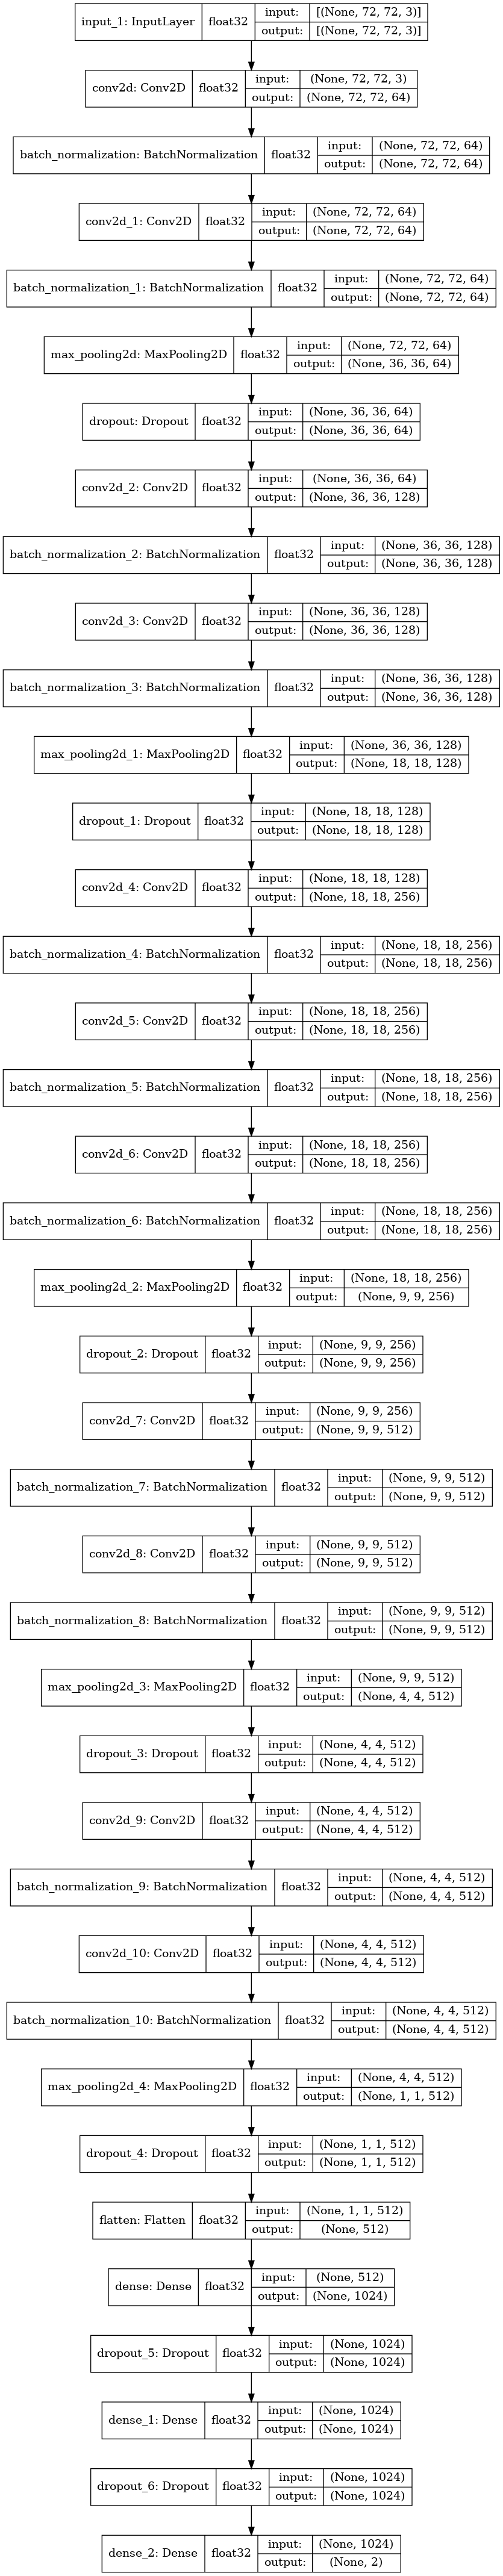

In [3]:
plot_model(exp_conv,
           to_file='custom_VggNET.png',
           show_dtype=True,
           show_shapes=True,
           show_layer_names=True)

In [4]:
exp_conv.compile(optimizer=Adam(),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

In [5]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='resnet.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]

In [6]:
generator = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=45,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)

train_gen = generator.flow_from_directory('../input/plant-or-not/',
                                          target_size=(72, 72),
                                          batch_size=376,
                                          subset='training')
validation_gen = generator.flow_from_directory('../input/plant-or-not/',
                                               target_size=(72, 72),
                                               batch_size=376,
                                               subset='validation')

Found 42205 images belonging to 2 classes.
Found 10550 images belonging to 2 classes.


In [7]:
train_gen.class_indices

{'resized_not_plant': 0, 'resized_plant': 1}

In [8]:
balancing_weight = {0:0.56,
                    1:5.02}

In [9]:
model_history = exp_conv.fit(train_gen,
                          epochs=150,
                          callbacks=callbacks,
                          validation_data=validation_gen,
                          class_weight=balancing_weight)

2022-01-27 12:17:55.743579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-01-27 12:17:59.397435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


113/113 [==============================] - 214s 2s/step - loss: 0.6173 - accuracy: 0.7869 - val_loss: 0.5606 - val_accuracy: 0.8261
Epoch 2/150
113/113 [==============================] - 132s 1s/step - loss: 0.3645 - accuracy: 0.8594 - val_loss: 0.6850 - val_accuracy: 0.6100
Epoch 3/150
113/113 [==============================] - 121s 1s/step - loss: 0.3100 - accuracy: 0.8887 - val_loss: 0.5494 - val_accuracy: 0.8438
Epoch 4/150
113/113 [==============================] - 123s 1s/step - loss: 0.2978 - accuracy: 0.8928 - val_loss: 0.2911 - val_accuracy: 0.9144
Epoch 5/150
113/113 [==============================] - 141s 1s/step - loss: 0.2684 - accuracy: 0.9027 - val_loss: 0.2629 - val_accuracy: 0.8934
Epoch 6/150
113/113 [==============================] - 119s 1s/step - loss: 0.2465 - accuracy: 0.9114 - val_loss: 0.2557 - val_accuracy: 0.8863
Epoch 7/150
113/113 [==============================] - 122s 1s/step - loss: 0.2259 - accuracy: 0.9173 - val_loss: 0.2902 - val_accuracy: 0.8761
Epoc

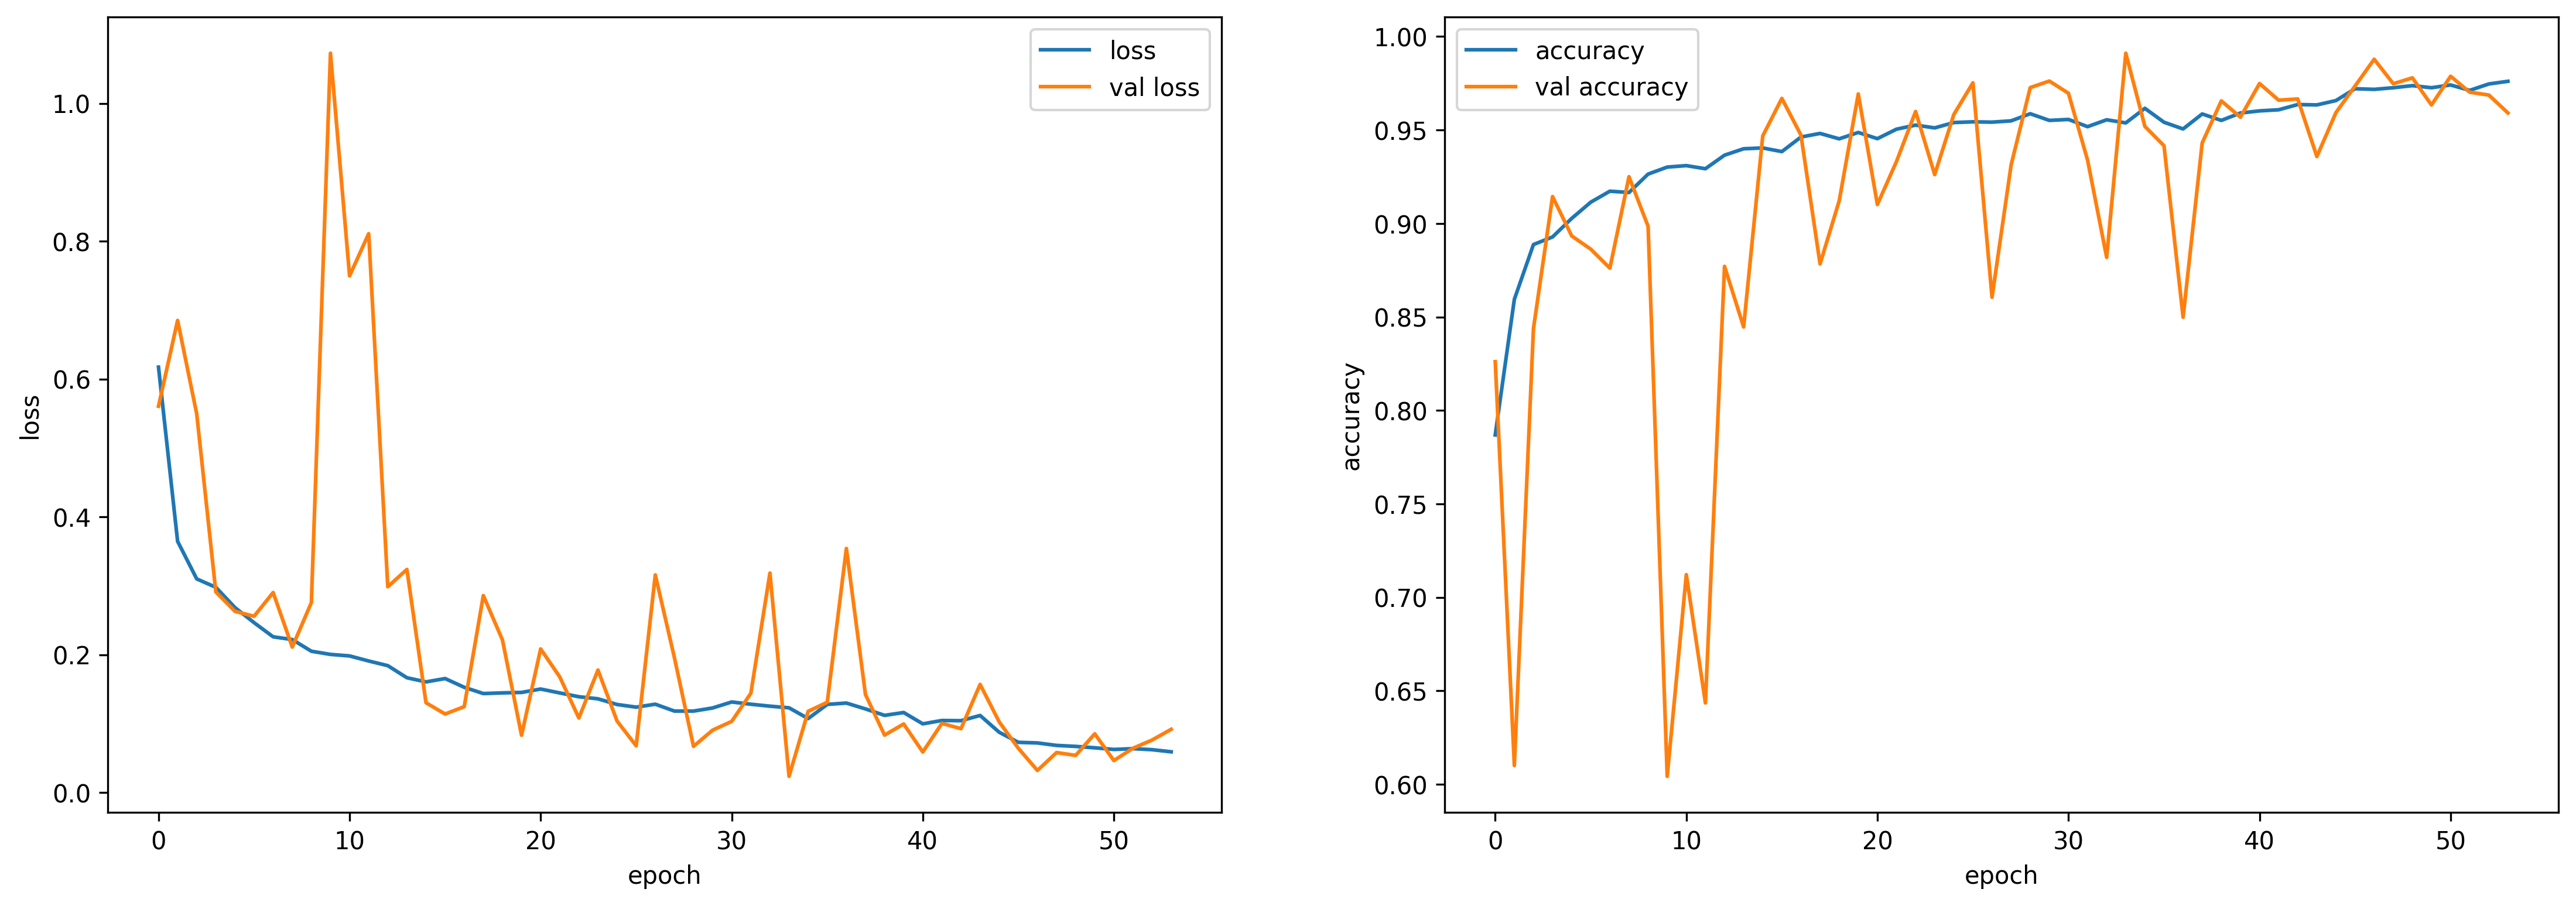

In [10]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(model_history.history['loss'])))

sns.lineplot(x=epochs, y=model_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=model_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=model_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=model_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('plant_train_history.png')
plt.show()

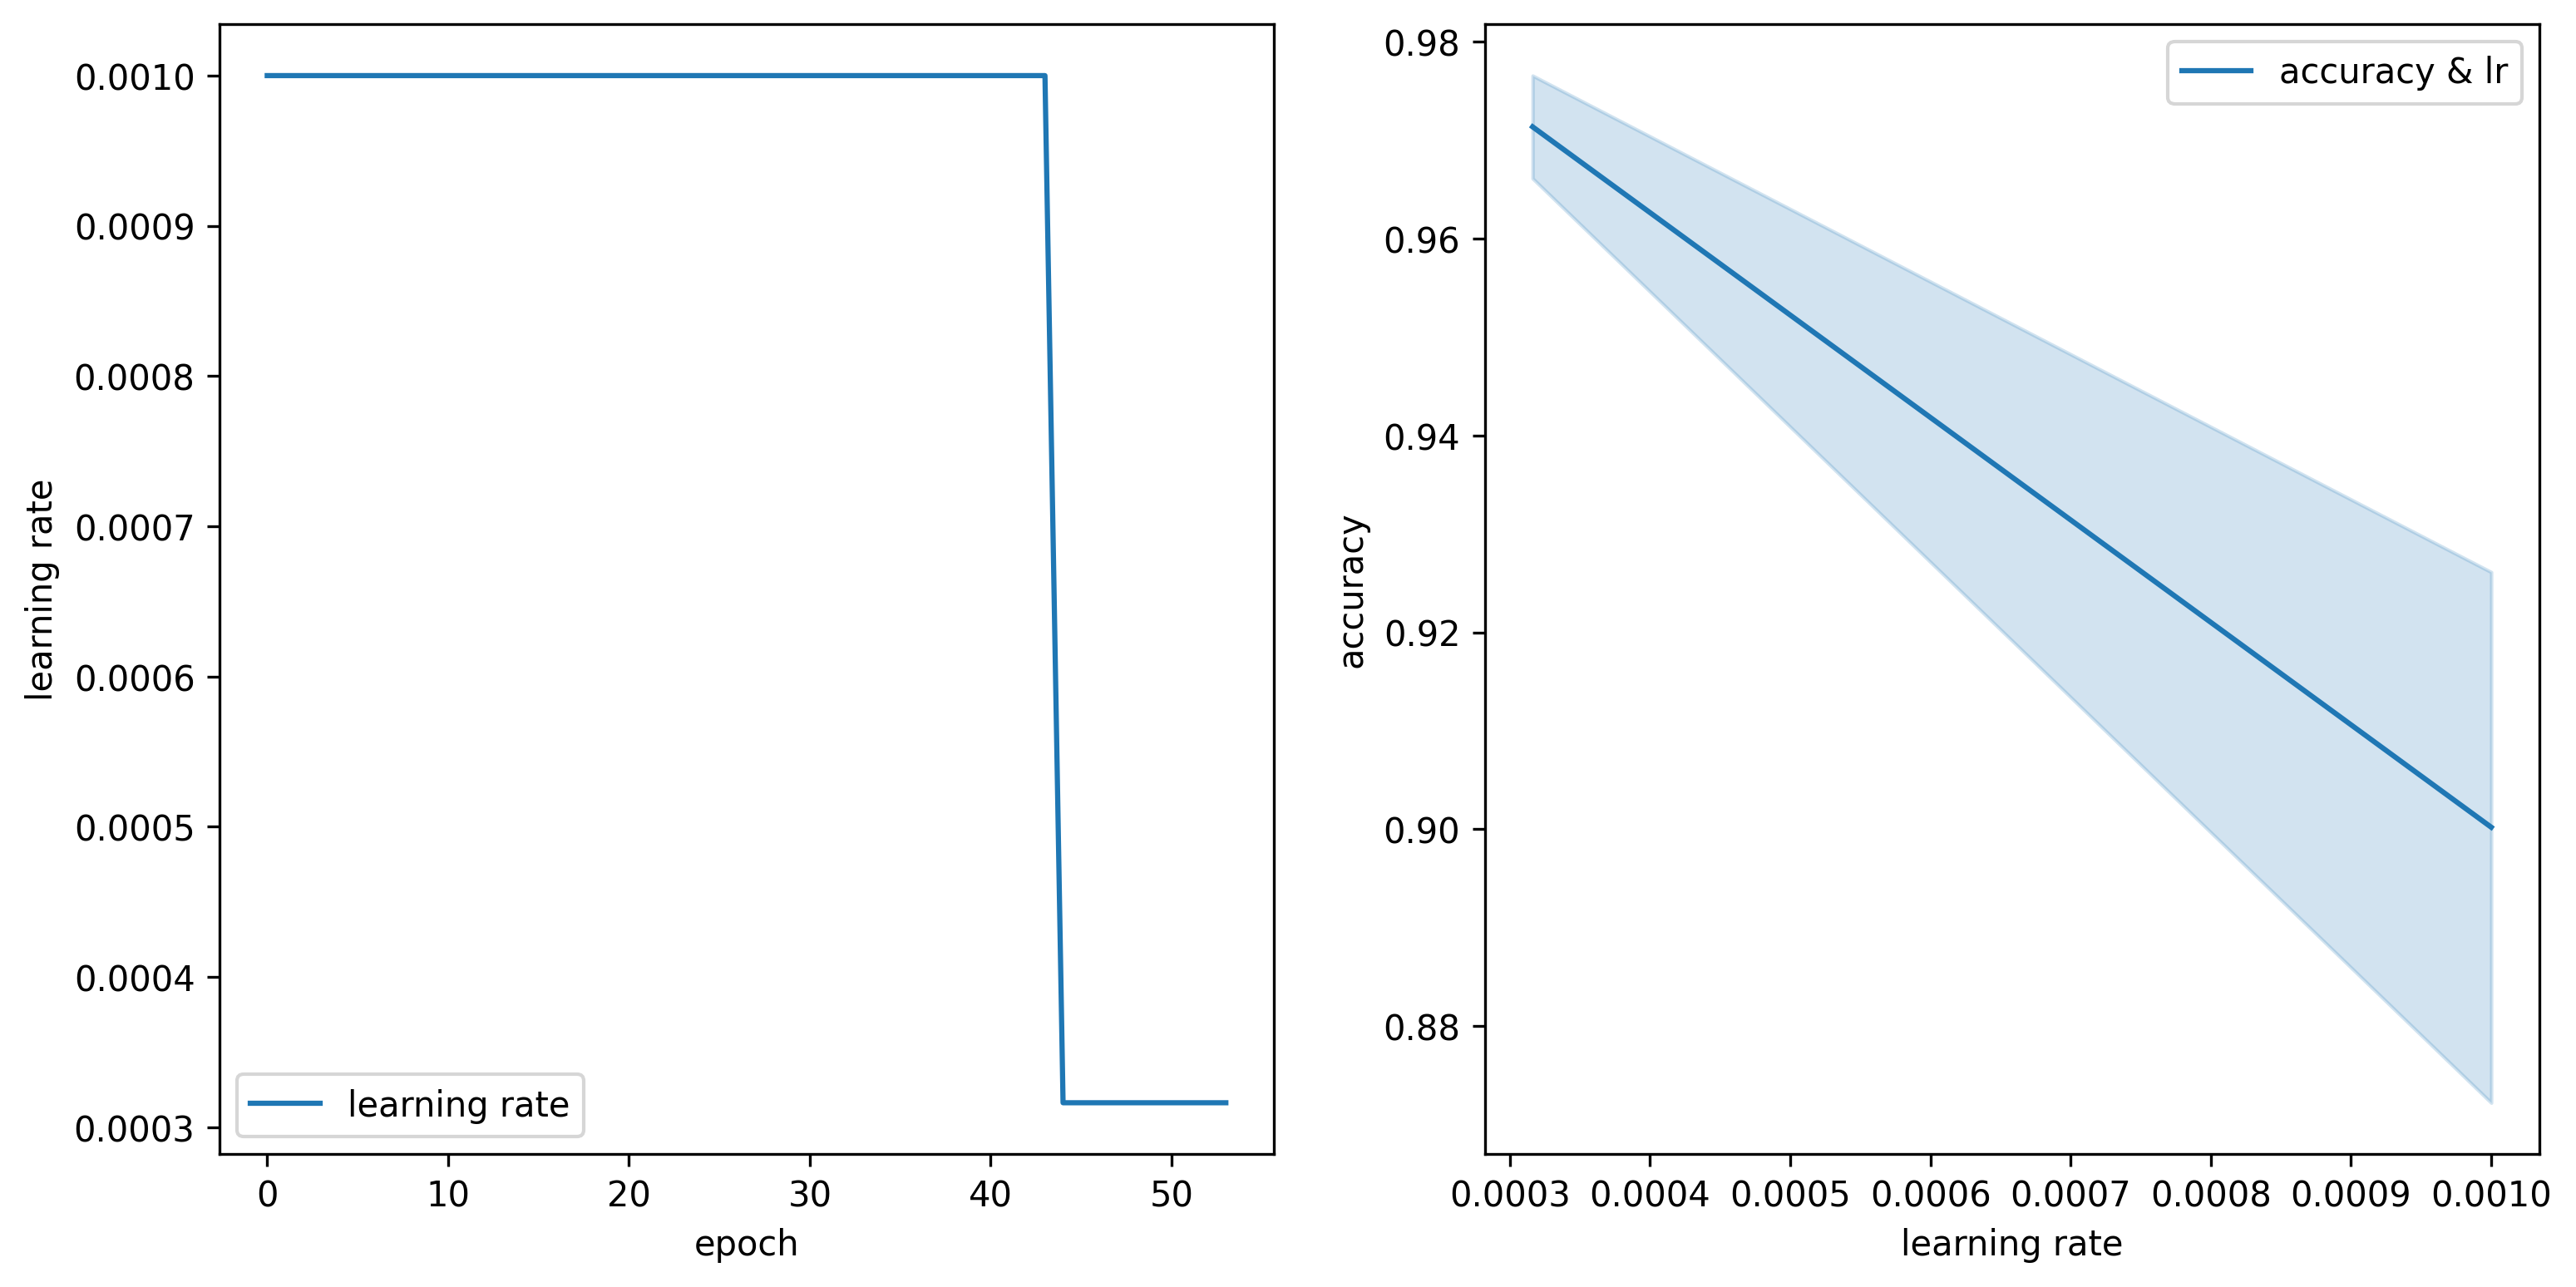

In [11]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=model_history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=model_history.history['lr'], y=model_history.history['val_accuracy'], ax=axes[1], label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('plant_lr_history.png')
plt.show()